En résumé, dans cette pratique nous allons voir comment déterminer les données futures avec les reseaux de neuronne avec LSTM (Long Short Term Memeory) qui permet de garder en memoire les informations qu'on lui a fourni ce qui rend les RNN très puissants.
Nous pouvons utiliser les algorithmes comme les Random Forest, les régressions linéaires et autres mais pour des predictions plus avancées nous utiliserons les reseau de neuronne. Connaitre dans le temps l'évolution de la pollution de l'air plus précisément de PM2.5.
Pour ceux qui veulent collecter les données et ensuite faire le pré traitement et appliquer le modèle là dessus, voici un exemple pour collecter les données pour la pollution de l'air. Ainsi une fois que vous récupérez vos données vous appliquez le modèle.

Ce modèle est bien adapté pour une tâche de prédiction de séries temporelles, comme prédire la qualité de l'air (PM2.5) pour un jour futur basé sur les jours précédents.

In [1]:
import requests

API_KEY = "1c7fd61e609f01bc6c6c0da3461f60e634ae15b2"#token
#city = "san-fernand"


In [2]:
lat = 33.5731  # Latitude de san-fernand
lon = -7.5898  # Longitude de san-fernand
url = f"http://api.waqi.info/feed/geo:{lat};{lon}/?token={API_KEY}"

response = requests.get(url)
data = response.json()
print(data)


{'status': 'ok', 'data': {'aqi': 18, 'idx': 8447, 'attributions': [{'url': 'http://www.juntadeandalucia.es/medioambiente/site/portalweb/', 'name': 'Consejería de Medio Ambiente y Ordenación del Territorio :: Junta de Andalucía', 'logo': 'Andalucia-Conserjeria-de-medio-ambiente.png'}, {'url': 'http://www.eea.europa.eu/themes/air/', 'name': 'European Environment Agency', 'logo': 'Europe-EEA.png'}, {'url': 'https://waqi.info/', 'name': 'World Air Quality Index Project'}], 'city': {'geo': [36.506015647598, -6.2685723945374], 'name': 'Avda. Marconi, Cadiz, Spain', 'url': 'https://aqicn.org/city/spain/andalucia/cadiz/avda.-marconi', 'location': ''}, 'dominentpol': 'o3', 'iaqi': {'dew': {'v': 18}, 'h': {'v': 82}, 'no2': {'v': 6}, 'o3': {'v': 18.4}, 'p': {'v': 1019}, 'pm10': {'v': 38}, 'pm25': {'v': 25}, 'so2': {'v': 1.6}, 't': {'v': 21}, 'w': {'v': 4.6}, 'wg': {'v': 12.8}}, 'time': {'s': '2024-10-25 12:00:00', 'tz': '+02:00', 'v': 1729857600, 'iso': '2024-10-25T12:00:00+02:00'}, 'forecast': {

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime

import math
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [4]:
df=pd.read_csv('C:/Users/efiom/Desktop/Outils/Projets/Admiral Consulting/PredictionEnvironementale/air-quality.csv')
df

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50
...,...,...,...,...,...,...
36187,2022-06-04 11:00:00,2022,6,4,11,35.89
36188,2022-06-04 12:00:00,2022,6,4,12,33.83
36189,2022-06-04 13:00:00,2022,6,4,13,33.05
36190,2022-06-04 14:00:00,2022,6,4,14,35.29


In [5]:
df.describe()

,Year,Month,Day,Hour,PM2.5
count,36192.000000,36192.000000,36192.000000,36192.000000,36192.000000
mean,2019.682278,6.331841,15.716401,11.477840,49.308429
std,1.345011,3.593321,8.859769,6.925088,24.863511
min,2017.000000,1.000000,1.000000,0.000000,7.020000
25%,2019.000000,3.000000,8.000000,5.000000,28.080000
50%,2020.000000,6.000000,16.000000,11.000000,45.730000
75%,2021.000000,10.000000,23.000000,17.000000,64.520000
max,2022.000000,12.000000,31.000000,23.000000,245.630000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36192 entries, 0 to 36191
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  36192 non-null  object 
 1   Year       36192 non-null  int64  
 2   Month      36192 non-null  int64  
 3   Day        36192 non-null  int64  
 4   Hour       36192 non-null  int64  
 5   PM2.5      36192 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.7+ MB


Nous allons converti Timestamp en format de date pour un bon modèle 

In [7]:
df['Timestamp']=pd.to_datetime(df['Timestamp']) 
#pd.to_datetime Convertit la colonne Timestamp en un objet datetime, permettant de manipuler les dates et heures plus facilement.

In [8]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


In [9]:
df['Date']=df['Timestamp'].dt.date
#dt.date. Returns numpy array of python datetime.date objects. Namely, the date part of Timestamps without time and timezone information.

In [10]:
df #so with this you can difference 

,Timestamp,Year,Month,Day,Hour,PM2.5,Date
0,2017-11-07 12:00:00,2017,11,7,12,64.51,2017-11-07
1,2017-11-07 13:00:00,2017,11,7,13,69.95,2017-11-07
2,2017-11-07 14:00:00,2017,11,7,14,92.79,2017-11-07
3,2017-11-07 15:00:00,2017,11,7,15,109.66,2017-11-07
4,2017-11-07 16:00:00,2017,11,7,16,116.50,2017-11-07
...,...,...,...,...,...,...,...
36187,2022-06-04 11:00:00,2022,6,4,11,35.89,2022-06-04
36188,2022-06-04 12:00:00,2022,6,4,12,33.83,2022-06-04
36189,2022-06-04 13:00:00,2022,6,4,13,33.05,2022-06-04
36190,2022-06-04 14:00:00,2022,6,4,14,35.29,2022-06-04


Visualization

    .Time series by days

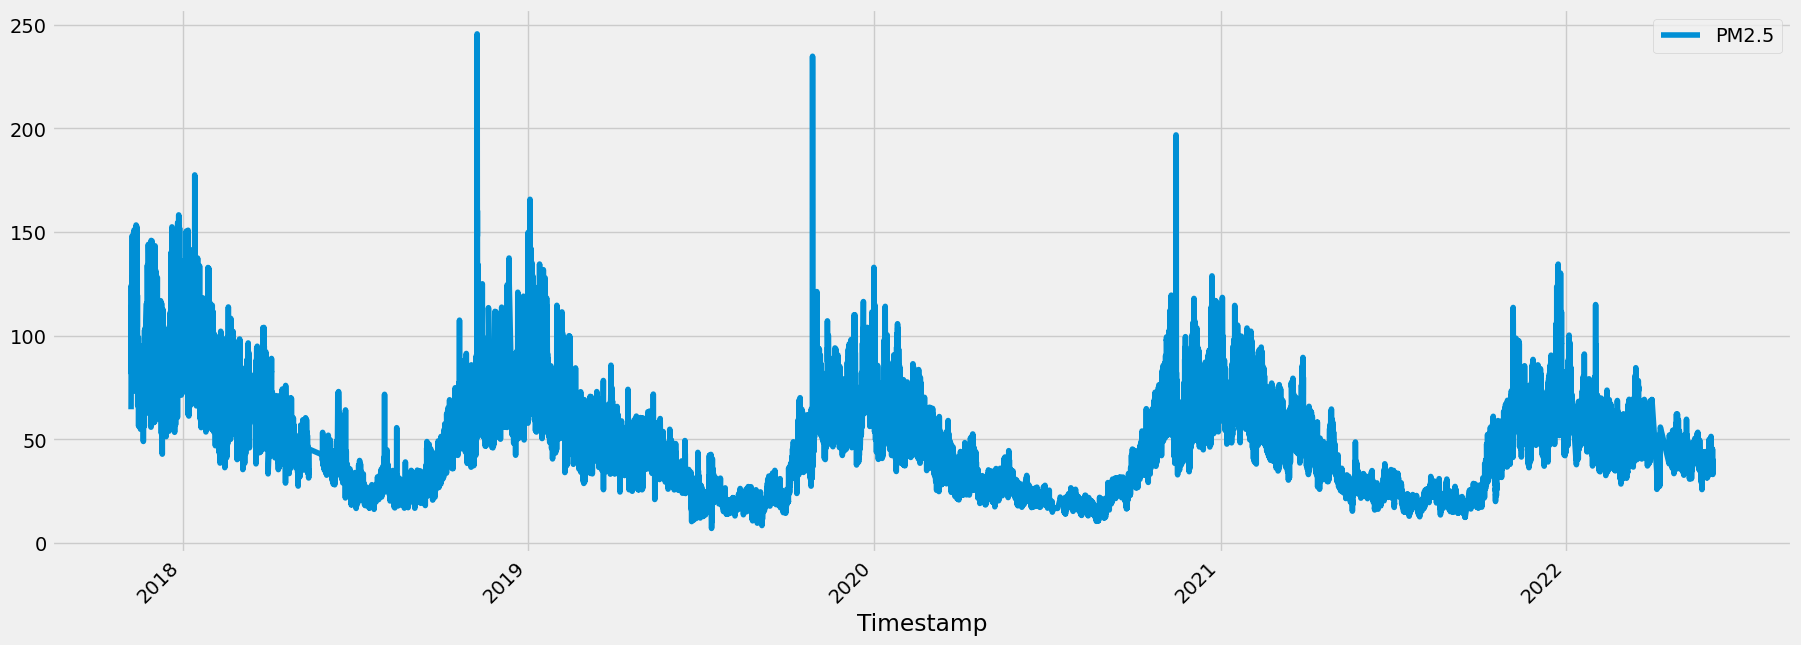

In [11]:
df.plot(x='Timestamp', y='PM2.5', figsize=(20, 8))
plt.xticks(rotation = 45) #rot=45 va disposer le date en x sur un angle de 45 degres

plt.show()

    Time series by year average

<Axes: xlabel='Year'>

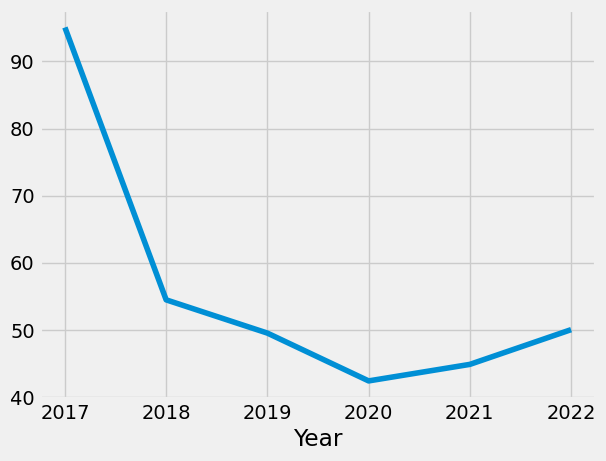

In [12]:
df.groupby('Year')['PM2.5'].mean().plot()

    Boxplot by year
    un boxplot (boîte à moustaches) qui permet de visualiser la distribution des valeurs de PM2.5 pour chaque année

<Axes: xlabel='Year', ylabel='PM2.5'>

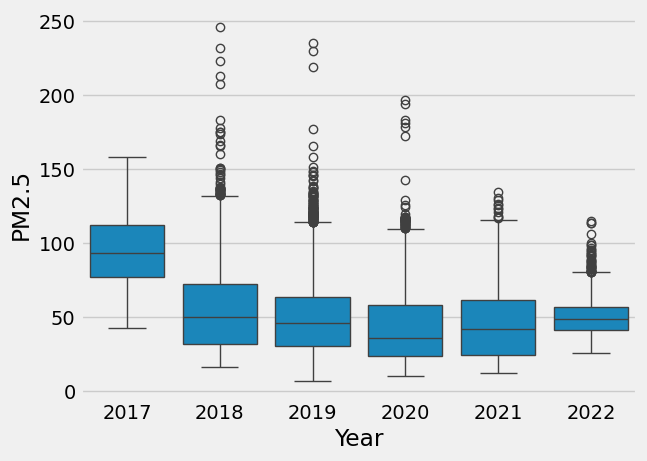

In [13]:
df_year= df.loc[:, ['Year', 'PM2.5']] #pour extraire deux colonnes spécifiques de ton DataFrame : Year et PM2.5.

sns.boxplot(x='Year', y='PM2.5', data=df_year)

Le : dans l'instruction df.loc[:, ['Year', 'PM2.5']] a une signification importante en pandas, et il est utilisé pour spécifier les parties du DataFrame que l'on souhaite sélectionner. Voici comment cela fonctionne :
Structure générale de .loc[] :

DataFrame.loc[rows, columns]

    rows : Spécifie les lignes qu'on veut sélectionner.
    columns : Spécifie les colonnes qu'on veut sélectionner.

Interprétation de : dans .loc[] :

    Sélection de toutes les lignes :
        : tout seul signifie "toutes les lignes". Autrement dit, : sélectionne l'intégralité des lignes du DataFrame, sans restriction.
    
    Exemple :

df.loc[:, ['Year', 'PM2.5']]

    Ici, : dans la première position (avant la virgule) signifie "prends toutes les lignes du DataFrame"....

Bon vous l'aurez compris

Interprétation du boxplot :

    Boîte (box) : Elle représente l'étendue des données centrales (du 1er quartile au 3e quartile, c’est-à-dire 50% des données).
    Ligne à l'intérieur de la boîte : Il s'agit de la médiane, c’est-à-dire la valeur centrale des données.
    Moustaches (whiskers) : Elles montrent l'étendue des données, mais excluent les valeurs aberrantes. Les moustaches s'étendent généralement jusqu'à 1,5 fois l'écart interquartile.
    Points en dehors des moustaches : Ils représentent les valeurs aberrantes (outliers), c'est-à-dire des valeurs qui se trouvent en dehors de l'étendue attendue des données.

Pourquoi ce boxplot est utile :

    Visualisation des distributions annuelles : Le boxplot permet de voir comment les niveaux de PM2.5 évoluent d'une année à l'autre, tout en montrant la dispersion des données, les valeurs extrêmes et la médiane.
    Comparer la pollution d'une année à l'autre : Si certaines années présentent des niveaux plus élevés ou plus de dispersion (avec des valeurs aberrantes), cela peut être un indicateur d'événements environnementaux significatifs cette année-là.

    Time series by month average

<Axes: xlabel='Month'>

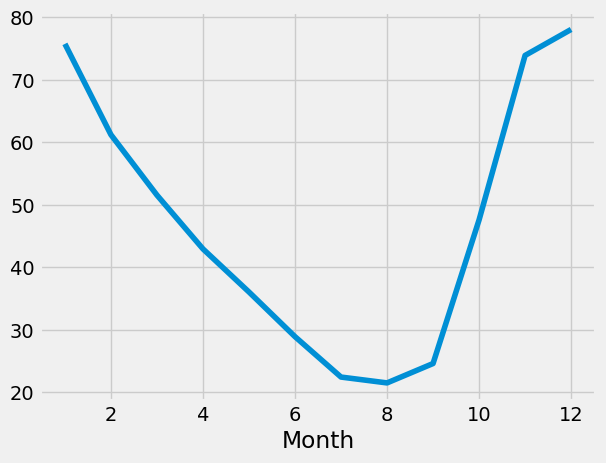

In [14]:
df.groupby('Month')['PM2.5'].mean().plot()

    Boxplot by month

<Axes: xlabel='Month', ylabel='PM2.5'>

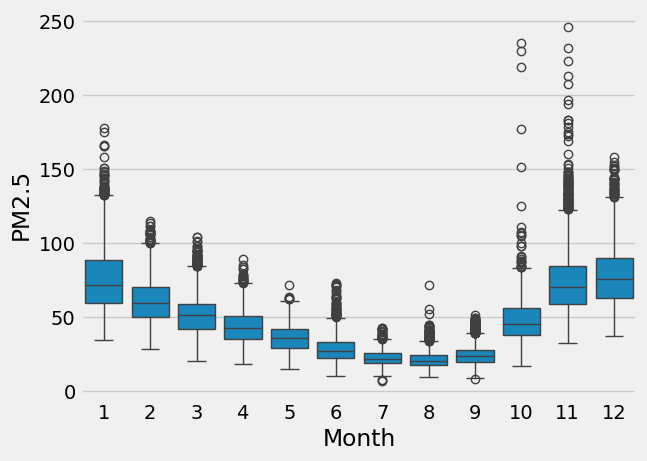

In [15]:
df_month=df.loc[:, ['Month', 'PM2.5']]
sns.boxplot(x='Month', y='PM2.5', data = df_month)

    Time series by day average

<Axes: xlabel='Day'>

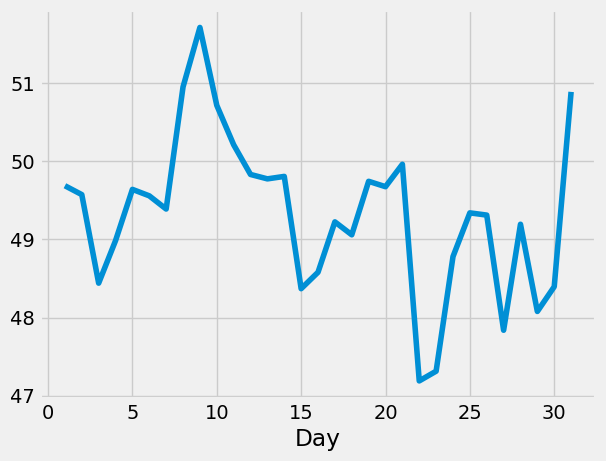

In [16]:
df.groupby('Day')['PM2.5'].mean().plot()

    Boxplot by day

<Axes: xlabel='Day', ylabel='PM2.5'>

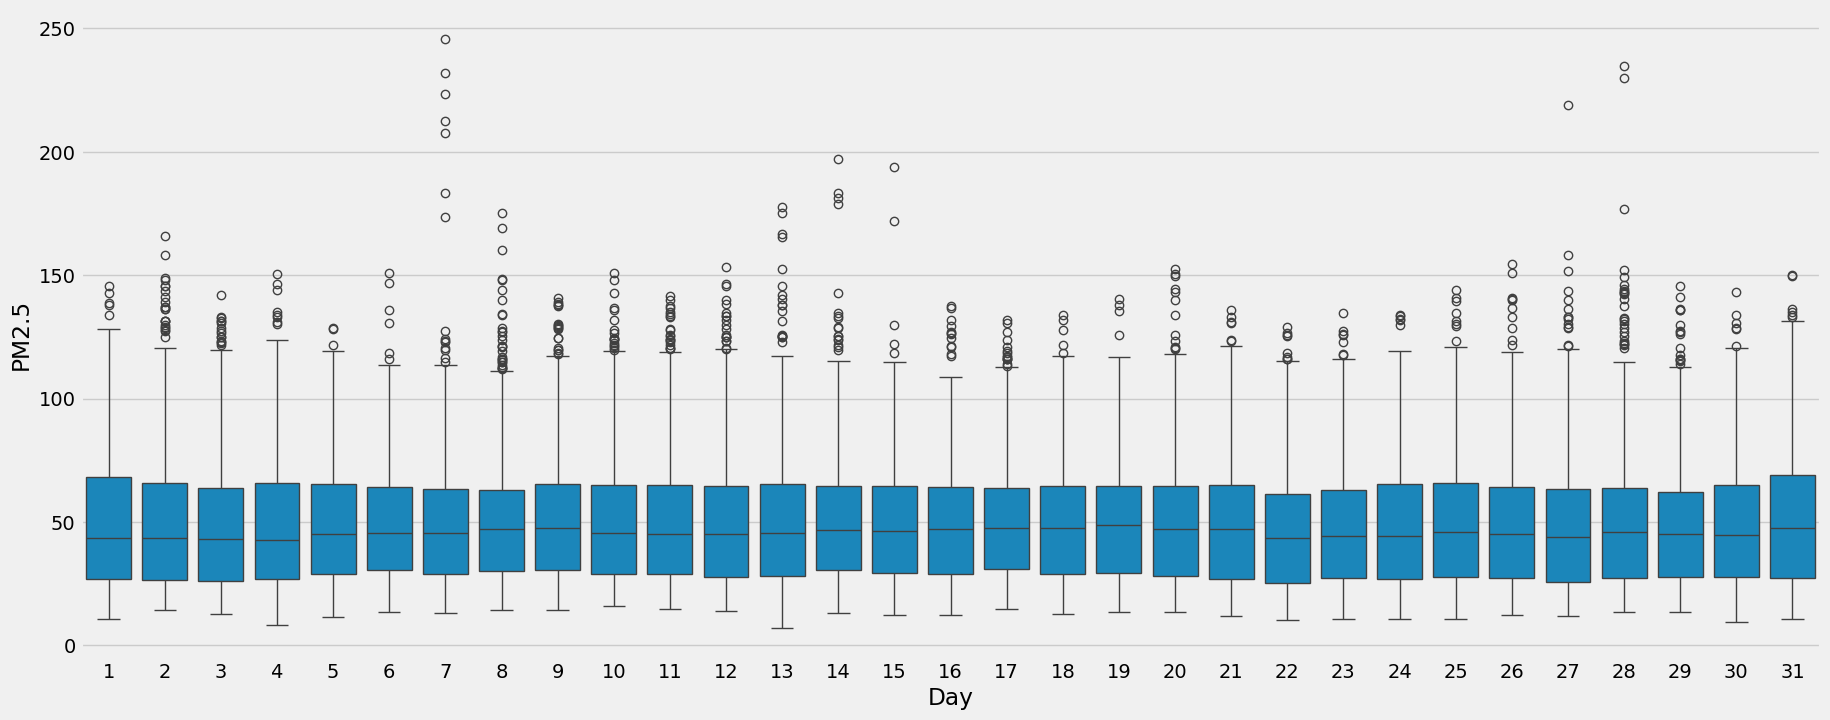

In [17]:
df_day=df.loc[:,['Day', 'PM2.5']]
plt.figure(figsize=(20, 8))
sns.boxplot(x='Day', y='PM2.5', data=df_day)

    Time series by hour average

<Axes: xlabel='Hour'>

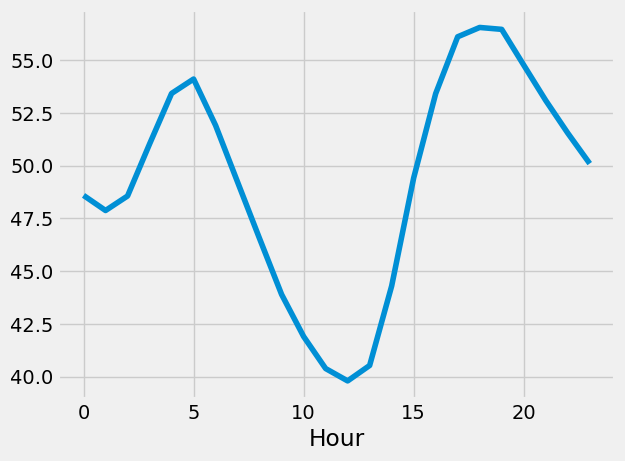

In [18]:
df.groupby('Hour')['PM2.5'].mean().plot()

    Boxplot by hour

<Axes: xlabel='Hour', ylabel='PM2.5'>

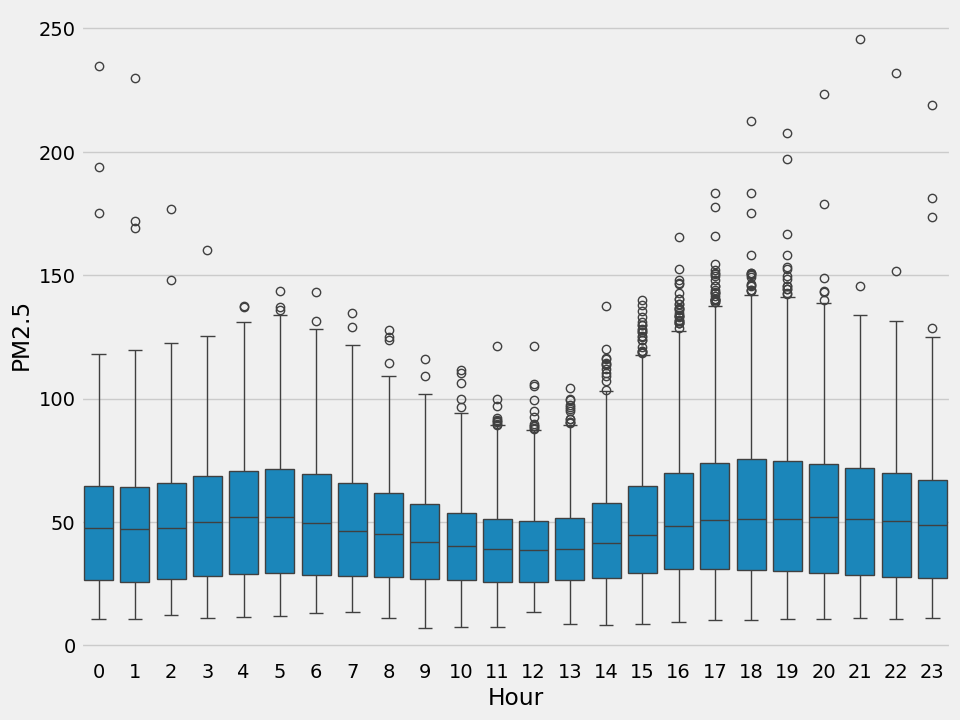

In [19]:
df_hour= df.loc[:, ['Hour', 'PM2.5']]
plt.figure(figsize=(10, 8))
sns.boxplot(x='Hour', y='PM2.5', data=df_hour)

Prediction Model

Le but c'est de savoir comment la pollution peut évoluer et en focntion de cela on s'aura si l'on doit se protèger ou pas.
Et donc pour faire la prediction, il faudrait que la prediction soit sur le jour, dans le but de savoir pour chaque jour,
comment serait la pollution en fonction de la moyenne quotidienne

Et donc ce que on va faire, je vais creer un DataFrame uniquement qui juste regrouper les jours en fonction de leur pollution moyenne

In [20]:
df_date= pd.DataFrame(df.groupby('Date')['PM2.5'].mean())#cela va creer le DataFrame df_fate
df_date

,PM2.5
Date,
2017-11-07,99.805833
2017-11-08,110.979565
2017-11-09,114.915833
2017-11-10,119.404091
2017-11-11,109.267273
...,...
2022-05-31,41.465417
2022-06-01,41.645833
2022-06-02,42.255417


    Time series by each days average

<Axes: xlabel='Date'>

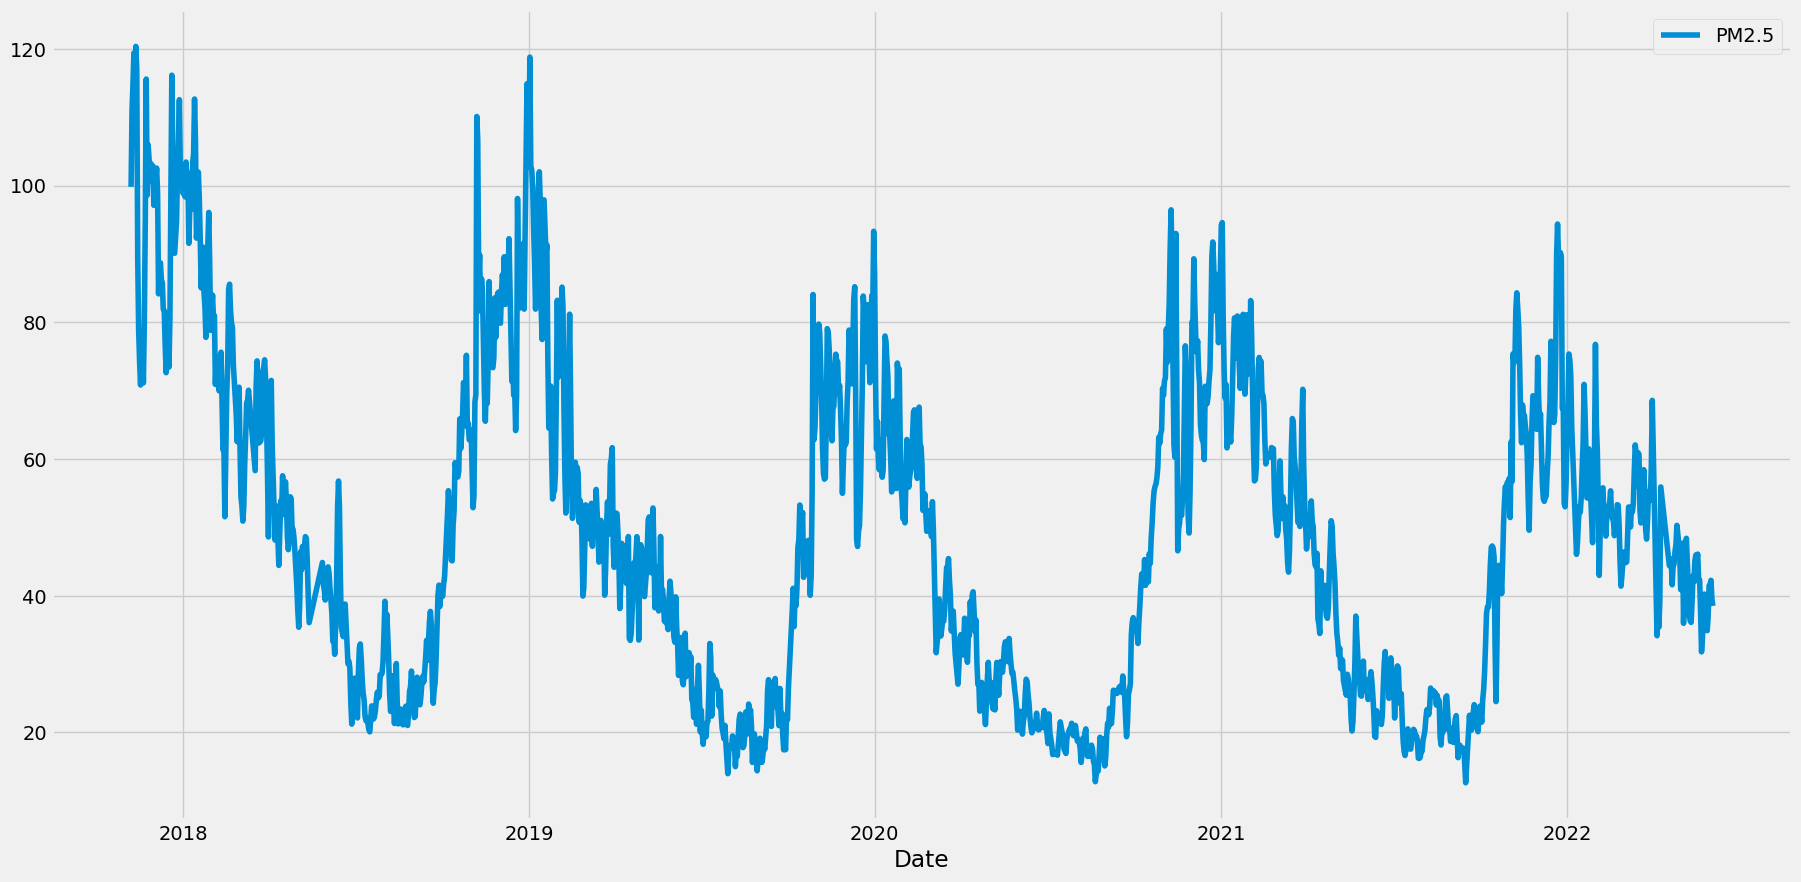

In [21]:
df_date.plot(figsize=(20, 10))

    Split data into train 80% and test 20%

In [22]:
dataset=df_date.values
training_data_len= math.ceil(len(dataset)*.8)
training_data_len

1293

math.ceil() : La fonction math.ceil() est utilisée pour arrondir le résultat à l'entier supérieur, de sorte qu'il n'y ait pas de fraction de données.

In [23]:
sc= MinMaxScaler(feature_range=(0, 1))
data_scaled= sc.fit_transform(dataset)

data_scaled

array([[0.80924161],
       [0.91297267],
       [0.94951492],
       ...,
       [0.27497376],
       [0.24870153],
       [0.24014526]])

ce code utilise un MinMaxScaler pour normaliser les données. L'objectif de cette étape est de transformer les données dans une plage spécifique (entre 0 et 1 dans ce cas) afin d'améliorer la performance des algorithmes de machine learning, notamment les réseaux de neurones

Sa formule est: Xscaled =(X − Xmin) / (Xmax − Xmin)

Cela signifie que la plus petite valeur de la série sera transformée en 0, et la plus grande valeur en 1, avec toutes les autres valeurs entre les deux.

scaled_data : Le résultat est un tableau NumPy contenant les valeurs normalisées.

feature_range=(0, 1) : Cela spécifie la plage dans laquelle les données seront transformées, ici entre 0 et 1.



fit_transform() : Cette méthode fait deux choses :

    fit() : Elle calcule les valeurs minimum et maximum de l'ensemble de données pour déterminer comment normaliser les valeurs.
    transform() : Ensuite, elle applique la transformation aux données (en utilisant la formule ci-dessus) pour toutes les lignes du dataset.

Je vais essayer de créer les ensembles de données d'entraînement (x_train et y_train) à partir des données normalisées, dans le but de les utiliser pour un modèle prédictif. J'utiliserai une approche glissante (ou fenêtre glissante) pour créer des séquences de données temporelles.

Cela est souvent utilisé pour des modèles comme les réseaux de neurones récurrents (RNN) ou les LSTM, qui sont particulièrement efficaces pour les données séquentielles.

In [24]:
train_data=data_scaled[0: training_data_len, :]#Cela prendra uniquement les données d'entraînement, c-à-d les 80 % des données qui ont été précédemment calculées dans training_data_len
x_train=[]
y_train=[]

num=60 #Ici, num est défini à 60, ce qui signifie que pour chaque prédiction, le modèle utilisera les 60 jours précédents pour prédire le 61e jour.
#Cela constitue une séquence d'entrée de longueur 60 pour chaque prédiction.

for i in range(num, len(train_data)):
    x_train.append(train_data[i- num:i, 0])#0 car le 1er indix(in a nuste une seule colonne)
    y_train.append(train_data[i, 0])# il va prendre la valeur a la postion i, (position au 61eme jour i=60), ajouter la valeur du 61e jr a y_train


range(num, len(train_data)) : Cette boucle commence à num (ici 60) et va jusqu'à la longueur totale de train_data. L'idée est de commencer à la 60e ligne et de regarder les 60 jours précédents pour créer une séquence.

x_train.append(train_data[i-num:i , 0]) :

    Pour chaque itération i, la séquence des 60 jours précédents (de i-60 à i-1) est ajoutée à x_train.
    train_data[i-num:i, 0] : Cela sélectionne les 60 jours précédents, de la position i-num (par exemple de 0 à 59 pour le premier tour) jusqu'à i-1 (par exemple 59 pour la première itération).

y_train.append(train_data[i, 0]) :

    train_data[i , 0] correspond à la valeur à prédire, c'est-à-dire la valeur de PM2.5 au 61e jour (ou à la position i). Elle est ajoutée à y_train.
    Cette valeur sera utilisée comme cible pour le modèle : le modèle prendra les 60 jours précédents pour prédire la 61e journée.

Exemple illustratif :

Si tu as les données suivantes (valeurs normalisées) :

scaled_data = [[0.1], [0.2], [0.3], ..., [0.6], [0.7], [0.8]]

Avec une fenêtre de num = 3, cela donnerait :

    Pour i = 3 (le quatrième jour) :
        x_train aura les trois jours précédents : [0.1, 0.2, 0.3]
        y_train sera la valeur du 4e jour : 0.4

    Pour i = 4 :
        x_train aura : [0.2, 0.3, 0.4]
        y_train sera : 0.5

Résultat :

Après cette boucle, x_train contiendra plusieurs séquences de 60 jours glissants, et y_train contiendra la valeur de PM2.5 que le modèle doit apprendre à prédire pour chaque séquence.




Pourquoi faire cela ?

    Apprentissage séquentiel : Les modèles comme les LSTM ou les RNN apprennent mieux avec des données séquentielles. En donnant des séquences de 60 jours, le modèle peut capturer les tendances temporelles et apprendre à prédire les valeurs futures de PM2.5.

In [25]:
x_train, y_train= np.array(x_train), np.array(y_train) #conversion des liste en tableau numpy pour bien l'integrer au model LSTM
x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #redimensionnment de x_train

x_train.shape

(1233, 60, 1)

(x_train.shape[0], x_train.shape[1], 1) spécifie la nouvelle forme de x_train :

    x_train.shape[0] correspond au nombre total de séquences dans x_train (le nombre d'exemples d'entraînement).
    x_train.shape[1] correspond à la longueur de chaque séquence (dans ton cas, 60 jours).
    1 ajoute une dimension supplémentaire à chaque séquence pour indiquer qu'il y a une seule caractéristique par jour (ici, uniquement PM2.5).

Pourquoi redimensionner de cette façon ?

Les modèles LSTM en machine learning sont conçus pour traiter des séquences temporelles et attendent donc une structure 3D pour leurs entrées :

    Première dimension : Le nombre de séquences (ou échantillons).
    Deuxième dimension : La longueur de chaque séquence (dans ce cas, 60 jours).
    Troisième dimension : Le nombre de caractéristiques par étape de temps (ici, 1, car on utilise uniquement les valeurs de PM2.5).

Cette transformation rend les données prêtes à être ingérées par le modèle LSTM pour l'entraînement.

Modeling

In [26]:
model = Sequential() #Sequential():Ce type de modèle empile les couches de manière séquentielle, chaque couche prenant l'output de la couche précédente comme input.
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1))) #True car on va envoyer cette couche a la couche suivante
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

LSTM(50) : Ajoute une couche LSTM avec 50 unités (ou neurones) dans cette couche. Chaque unité LSTM peut apprendre des dépendances temporelles dans les données.
return_sequences=True : Cela signifie que la couche retourne toute la séquence (c’est-à-dire toutes les étapes de temps) en sortie. Cela est nécessaire car nous allons passer cette séquence en entrée à une autre couche LSTM.
input_shape=(x_train.shape[1], 1) : Définit la forme de l'input attendu par la première couche LSTM. Ici :

    x_train.shape[1] correspond à la longueur de chaque séquence (dans ton cas, 60).
    1 représente le nombre de caractéristiques par pas de temps (uniquement PM2.5 ici).

LSTM(50) : Ajoute une autre couche LSTM avec 50 unités.
return_sequences=False : Cela signifie que cette couche ne renvoie que le dernier output de la séquence (pas la séquence entière), car nous passons ensuite à des couches denses pour générer la prédiction finale.

Dense(25) : Ajoute une couche dense entièrement connectée avec 25 neurones. Cette couche aide à capturer les relations complexes dans les données après les couches LSTM.

Dense(1) : Ajoute la couche de sortie avec un seul neurone, car nous prédisons une seule valeur (la prochaine valeur de PM2.5).

Vue d'ensemble du modèle

    LSTM (50 neurones, output séquentiel) : Capture les dépendances temporelles dans les 60 jours précédents.
    LSTM (50 neurones, output final) : Résume l'information à travers toute la séquence en ne retournant que le dernier état.
    Dense (25 neurones) : Transforme l’output de l'étape précédente pour apprendre des relations plus complexes.
    Dense (1 neurone) : Génère la prédiction finale pour la prochaine valeur de PM2.5.

In [27]:
#on passe a la compilation du model en spécifiant l'optimiseur et la fonction de perte, ce qui configure le modèle pour l'entraînement.
model.compile(optimizer="adam",  loss="mean_squared_error")

optimizer="adam" :

    Adam (Adaptive Moment Estimation) est un optimiseur populaire en machine learning qui ajuste les poids de manière adaptative en utilisant les moments des gradients (moyenne et variance).
    Il combine les avantages des optimisateurs RMSprop et SGD avec momentum, permettant une convergence rapide et stable.

loss="mean_squared_error" :

    Mean Squared Error (MSE) est une mesure de la différence moyenne au carré entre les valeurs réelles et les valeurs prédites.
    Elle est souvent utilisée pour les tâches de régression, car elle pénalise fortement les erreurs importantes, incitant le modèle à réduire les grandes erreurs.

Finalité

Avec cette configuration :

    Adam ajustera les paramètres du modèle pendant l'entraînement pour minimiser l'erreur.
    Mean Squared Error servira de métrique pour évaluer la performance du modèle sur les données d’entraînement et d’éventuels jeux de test.

In [28]:
model.fit(x_train, y_train, batch_size=1, epochs=1, verbose=1)

1233/1233 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.0118


batch_size=1 signifie que le modèle ajuste ses poids après chaque échantillon. Cela permet un ajustement fréquent des poids, bien que cela puisse être plus lent pour les grands ensembles de données.
Une taille de batch de 1 est souvent utilisée pour les séries temporelles, mais pour des données volumineuses, une taille de batch plus élevée peut être plus efficace.

Prediction
    On prépare les données de test pour évaluer le modèle

In [29]:
#pour faire le test, on doit se referer a la sequence precedente, donc nos test vont commencer 60 jour avant le moment de prediction
test_data= data_scaled[training_data_len - 60:, :]
x_test=[]
y_test=dataset[training_data_len:, :]

for i in range(num, len(test_data)):
    x_test.append(test_data[i - num: i, 0])

scaled_data[training_data_len-60:, :] :

    Cette ligne sélectionne les données de test de scaled_data, en prenant un segment commençant à 60 valeurs avant la fin des données d’entraînement (indice training_data_len-60) jusqu'à la fin des données.
    Les 60 premières valeurs sont ajoutées pour pouvoir constituer la première séquence de test complète (60 jours) pour faire la prédiction du premier jour après l'entraînement.

    y_test = dataset[training_data_len:, :] : Sélectionne les vraies valeurs de PM2.5 du jeu de test, que le modèle tentera de prédire.

    Ces valeurs couvrent tous les jours qui suivent le jeu d’entraînement.
        test_data[i-num:i, 0] : Sélectionne les 60 valeurs précédentes de PM2.5, qui composent une séquence d’entrée pour x_test.

Cette approche glissante crée une série de sous-ensembles de x_test, chacun contenant les 60 jours nécessaires pour prédire la valeur suivante.

In [30]:
#comme avant on convertit les listes et con redimensionne les donnees
x_test= np.array(x_test)
x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [31]:
#prediction
predictions= model.predict(x_test)
predictions= sc.inverse_transform(predictions)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


sc.inverse_transform(predictions) : Transforme les valeurs prédites de retour à leur échelle originale en utilisant l’inverse de la normalisation initiale.
    vu que avant nos données ont été normalisées avant de faire le modèle, donc on va les faire retourner a leurs valeurs origianles
Cela permet de comparer directement les prédictions avec les vraies valeurs de PM2.5 dans y_test.

In [32]:
rmse= np.sqrt(np.mean(predictions - y_test)**2)
rmse

2.2097931492108116

Calcul du RMSE (Root Mean Squared Error)
    
    predictions - y_test : Calcule les erreurs en soustrayant les vraies valeurs de test (y_test) aux valeurs prédites.
    (predictions - y_test)**2 : Élève chaque erreur au carré pour obtenir l'erreur quadratique.
    np.mean(...) : Calcule la moyenne de ces erreurs quadratiques.
    np.sqrt(...) : Prend la racine carrée pour obtenir l'erreur quadratique moyenne (RMSE).

Le RMSE fournit une mesure de l'écart moyen entre les prédictions et les vraies valeurs. Plus il est faible, plus le modèle est précis.

In [33]:
train= df_date[:training_data_len]
valid= df_date[training_data_len:]
valid['Predictions']=predictions #creer la colonne "Prediction" et ajouter predictions
valid

,PM2.5,Predictions
Date,,
2021-06-28,28.667917,26.660563
2021-06-29,30.903750,26.586094
2021-06-30,29.017917,27.116556
2021-07-01,27.166667,27.425110
2021-07-02,27.132917,27.256386
...,...,...
2022-05-31,41.465417,35.167828
2022-06-01,41.645833,36.062706
2022-06-02,42.255417,37.158733


<Axes: xlabel='Date'>

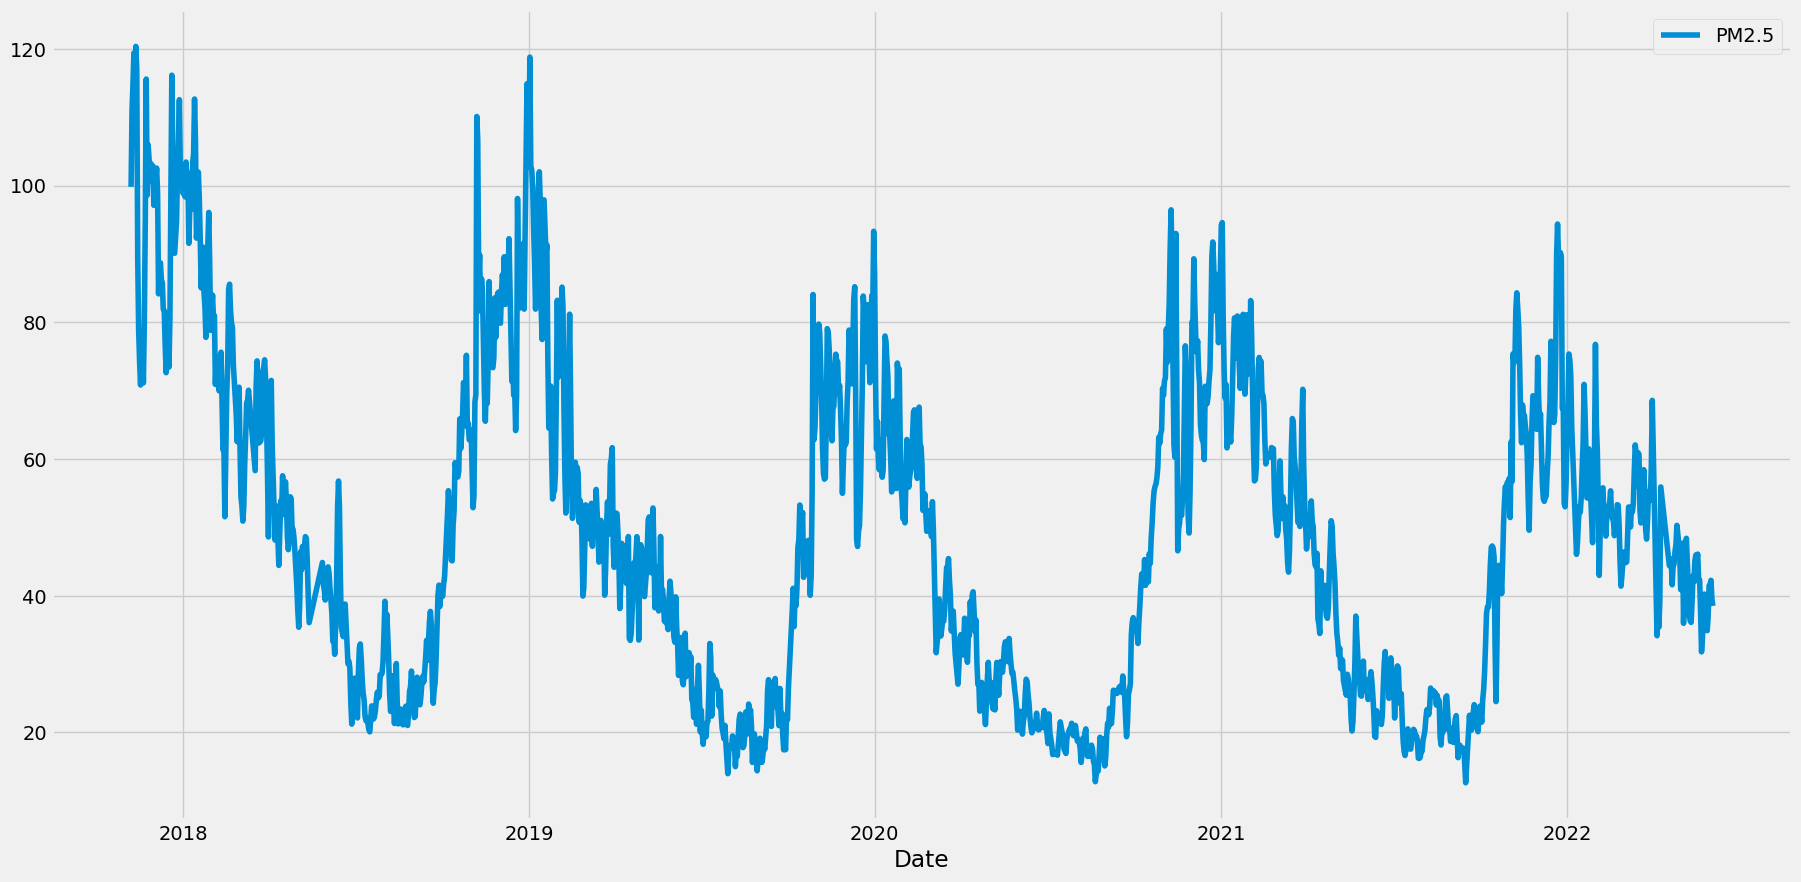

In [34]:
#visualisation des donnees relles
df_date.plot(figsize=(20, 10))

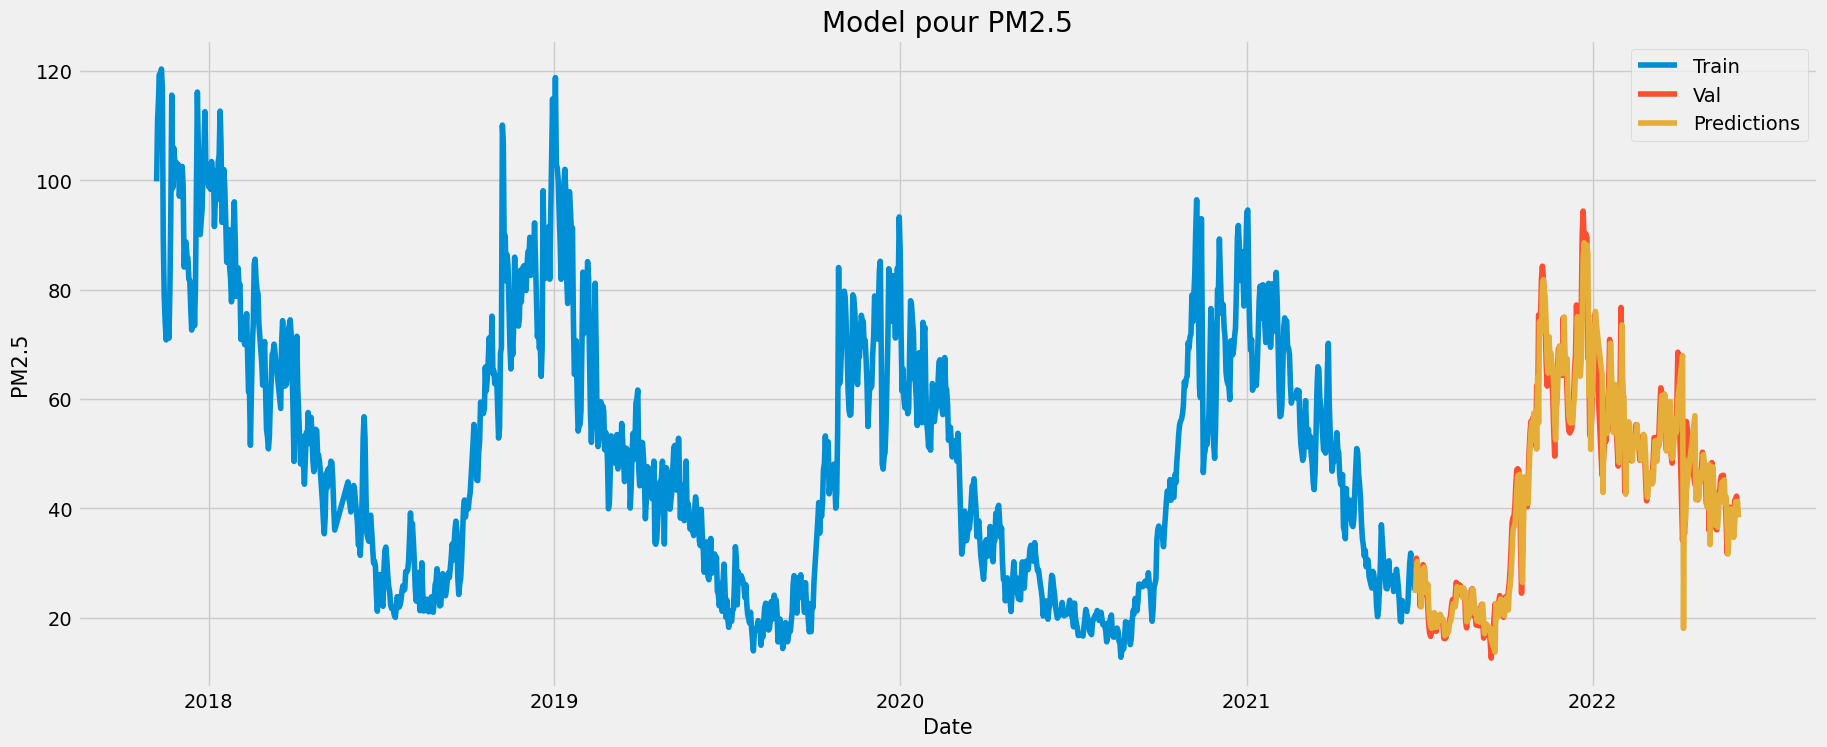

In [86]:
plt.figure(figsize=(20,8))
plt.title('Model pour PM2.5')
plt.xlabel('Date', fontsize=15)
plt.ylabel('PM2.5', fontsize=15)
plt.plot(train[df_date.columns])
plt.plot(valid['PM2.5'])
plt.plot(valid['Predictions'])
plt.legend(["Train", "Val", "Predictions"])


In [36]:
#save de la hierarchi du mode
LSTM=model.to_json()

with open("LSTM.json", "w") as json_file:
    json_file.write(LSTM)

#save des poids
model.save_weights("LSTM.weights.h5")
print("save to disk")

save to disk
